In [131]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [132]:
!pip install grad-cam

In [133]:
import torch
from torch import nn 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import glob 
from random import sample

In [134]:

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [135]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Import all models

In [136]:
from torchvision.models import inception_v3,resnet50, vgg16_bn, resnext50_32x4d, mobilenet_v3_large

w_inception = torch.load("/kaggle/input/inceptionv3-skin-cancer/model_inception_finetune_e10.pth")
w_resnet = torch.load("/kaggle/input/resnet-50/model_resnet50_finetune_e10.pth")
w_vgg = torch.load("/kaggle/input/vgg-16-bn-freeze-e40/model_vgg16_bn_freeze_e40.pth")
w_mobilenet = torch.load("/kaggle/input/mobilenetv3-last-epoch/model_MobileNetV3_finetune_e10.pth")

In [137]:
inception = inception_v3().to(device)
resnet = resnet50().to(device)
vgg = vgg16_bn().to(device)
mobilenet = mobilenet_v3_large().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [138]:
num_ftrs = inception.fc.in_features
inception.fc = nn.Linear(num_ftrs, 1)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)

num_ftrs = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_ftrs, 1)

mobilenet.classifier[3] = torch.nn.Linear(mobilenet.classifier[3].in_features, 1)

In [139]:
inception.load_state_dict(w_inception['model_state_dict'])
resnet.load_state_dict(w_resnet['model_state_dict'])
vgg.load_state_dict(w_vgg['model_state_dict'])
mobilenet.load_state_dict(w_mobilenet['model_state_dict'])

<All keys matched successfully>

In [140]:
t_resnet = v2.Compose([
    
    v2.Resize(232,interpolation= v2.InterpolationMode.BILINEAR),
    v2.CenterCrop(224),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),

])

t_inception = v2.Compose([
    
    v2.Resize(342,interpolation= v2.InterpolationMode.BILINEAR),
    v2.CenterCrop(299),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),

])

t_vgg = v2.Compose([
    
    v2.Resize(232,interpolation= v2.InterpolationMode.BILINEAR),
    v2.CenterCrop(224),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

])

t_mobilenet = v2.Compose([
    
    v2.Resize(232,interpolation= v2.InterpolationMode.BILINEAR),
    v2.CenterCrop(224),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),

])

transform_norm = v2.Compose([    #ToTensor()
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [193]:
class ham(Dataset):
    def __init__(self,csv_dir,transform = None):
        self.csv_dir = csv_dir
        self.datas = pd.read_csv(self.csv_dir)
        self.transform = transform
        
    def __getitem__(self,x):
        
        path = self.datas.path[x]
        img = Image.open(path)
        label = self.datas.label[x]
        label = torch.tensor(label, dtype = torch.float32)
        if self.transform:
            img = self.transform(img)
            
        return img, label
    
    def __len__(self):
        return len(self.datas)
    
test_resnet = ham("/kaggle/working/false_negetive.csv",t_resnet)
test_inception = ham("/kaggle/working/false_negetive.csv",t_inception)
test_vgg = ham("/kaggle/working/false_negetive.csv",t_vgg)
test_mobilenet = ham("/kaggle/working/false_negetive.csv",t_mobilenet)

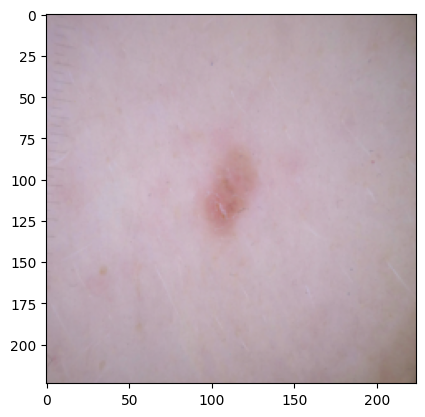

In [194]:
plt.imshow((test_resnet[0][0]).permute(2,1,0))

In [196]:
resnet_dataloader = DataLoader(dataset= test_resnet,
                              batch_size= 4,
                              shuffle= False
                              )
inception_dataloader = DataLoader(dataset= test_inception,
                              batch_size= 4,
                              shuffle= False
                              )
vgg_dataloader = DataLoader(dataset= test_vgg,
                              batch_size= 4,
                              shuffle= False
                              )
mobilenet_dataloader = DataLoader(dataset= test_mobilenet,
                              batch_size= 4,
                              shuffle= False
                              )

In [197]:
img_inception ,label = next(iter(inception_dataloader))
img_inception = img_inception.to("cpu")
img_inception_norm = transform_norm(img_inception).to(device)

img_resnet ,label = next(iter(resnet_dataloader))
img_resnet = img_resnet.to("cpu")
img_resnet_norm = transform_norm(img_resnet).to(device)

img_vgg ,label = next(iter(vgg_dataloader))
img_vgg = img_vgg.to("cpu")
img_vgg_norm = transform_norm(img_vgg).to(device)

img_mobilenet ,label = next(iter(mobilenet_dataloader))
img_mobilenet = img_mobilenet.to("cpu")
img_mobilenet_norm = transform_norm(img_mobilenet).to(device)


In [198]:
resnet.to(device)
resnet_target_layers = [resnet.layer4[-1]]
res_cam = ScoreCAM(model=resnet, target_layers=resnet_target_layers)
res_hitmaps = res_cam(input_tensor=img_resnet_norm)

100%|██████████| 128/128 [00:03<00:00, 36.87it/s]


In [199]:
vgg.to(device)
vgg_target_layers = [vgg.features[-1]]
vgg_cam = ScoreCAM(model=vgg, target_layers=vgg_target_layers)
vgg_hitmaps = vgg_cam(input_tensor=img_vgg_norm)

100%|██████████| 32/32 [00:01<00:00, 22.53it/s]


In [200]:
# grayscale_cam[3]

In [201]:
# (img_resnet[0] * 255).round().int()

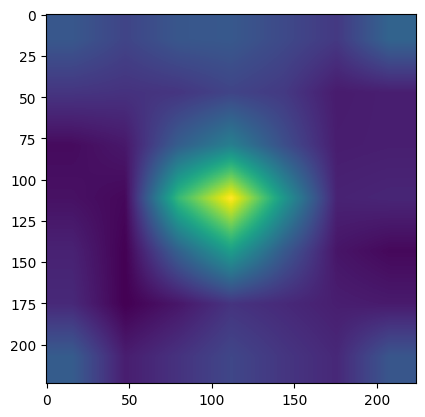

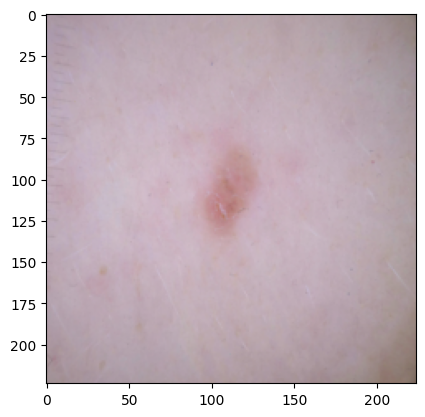

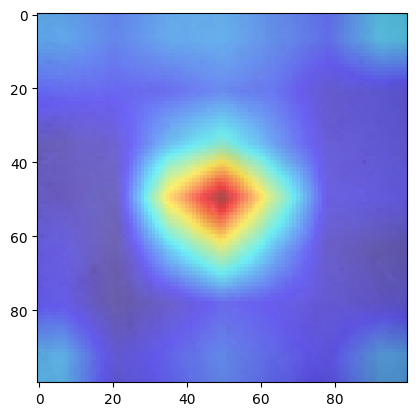

In [202]:
visualization = show_cam_on_image(img_vgg[0].permute(2,1,0).cpu().numpy(), vgg_hitmaps[0], use_rgb=True)
plt.imshow(vgg_hitmaps[0])
plt.show()
plt.imshow((img_vgg[0] * 255).round().int().permute(2,1,0).cpu().numpy())
plt.show()
plt.imshow(cv.resize(visualization,(100,100)))
plt.show()

In [203]:
inception.eval()
with torch.no_grad():
    inception.to(device)
    inception_result = list(torch.sigmoid(inception(img_inception_norm)).round().squeeze(dim =1).int().cpu().numpy())
    
resnet.eval()
with torch.no_grad():
    resnet.to(device)
    resnet_result = list(torch.sigmoid(resnet(img_resnet_norm)).round().squeeze(dim =1).int().cpu().numpy())

vgg.eval()
with torch.no_grad():
    vgg.to(device)
    vgg_result = list(torch.sigmoid(vgg(img_vgg_norm)).round().squeeze(dim =1).int().cpu().numpy())
    
mobilenet.eval()
with torch.no_grad():
    mobilenet.to(device)
    mobilenet_result = list(torch.sigmoid(mobilenet(img_mobilenet_norm)).round().squeeze(dim =1).int().cpu().numpy())
    
label = list(label.int().cpu().numpy())

In [204]:
mobilenet_result

[0, 0, 0, 0]

In [153]:
label

[0, 0, 0, 0]

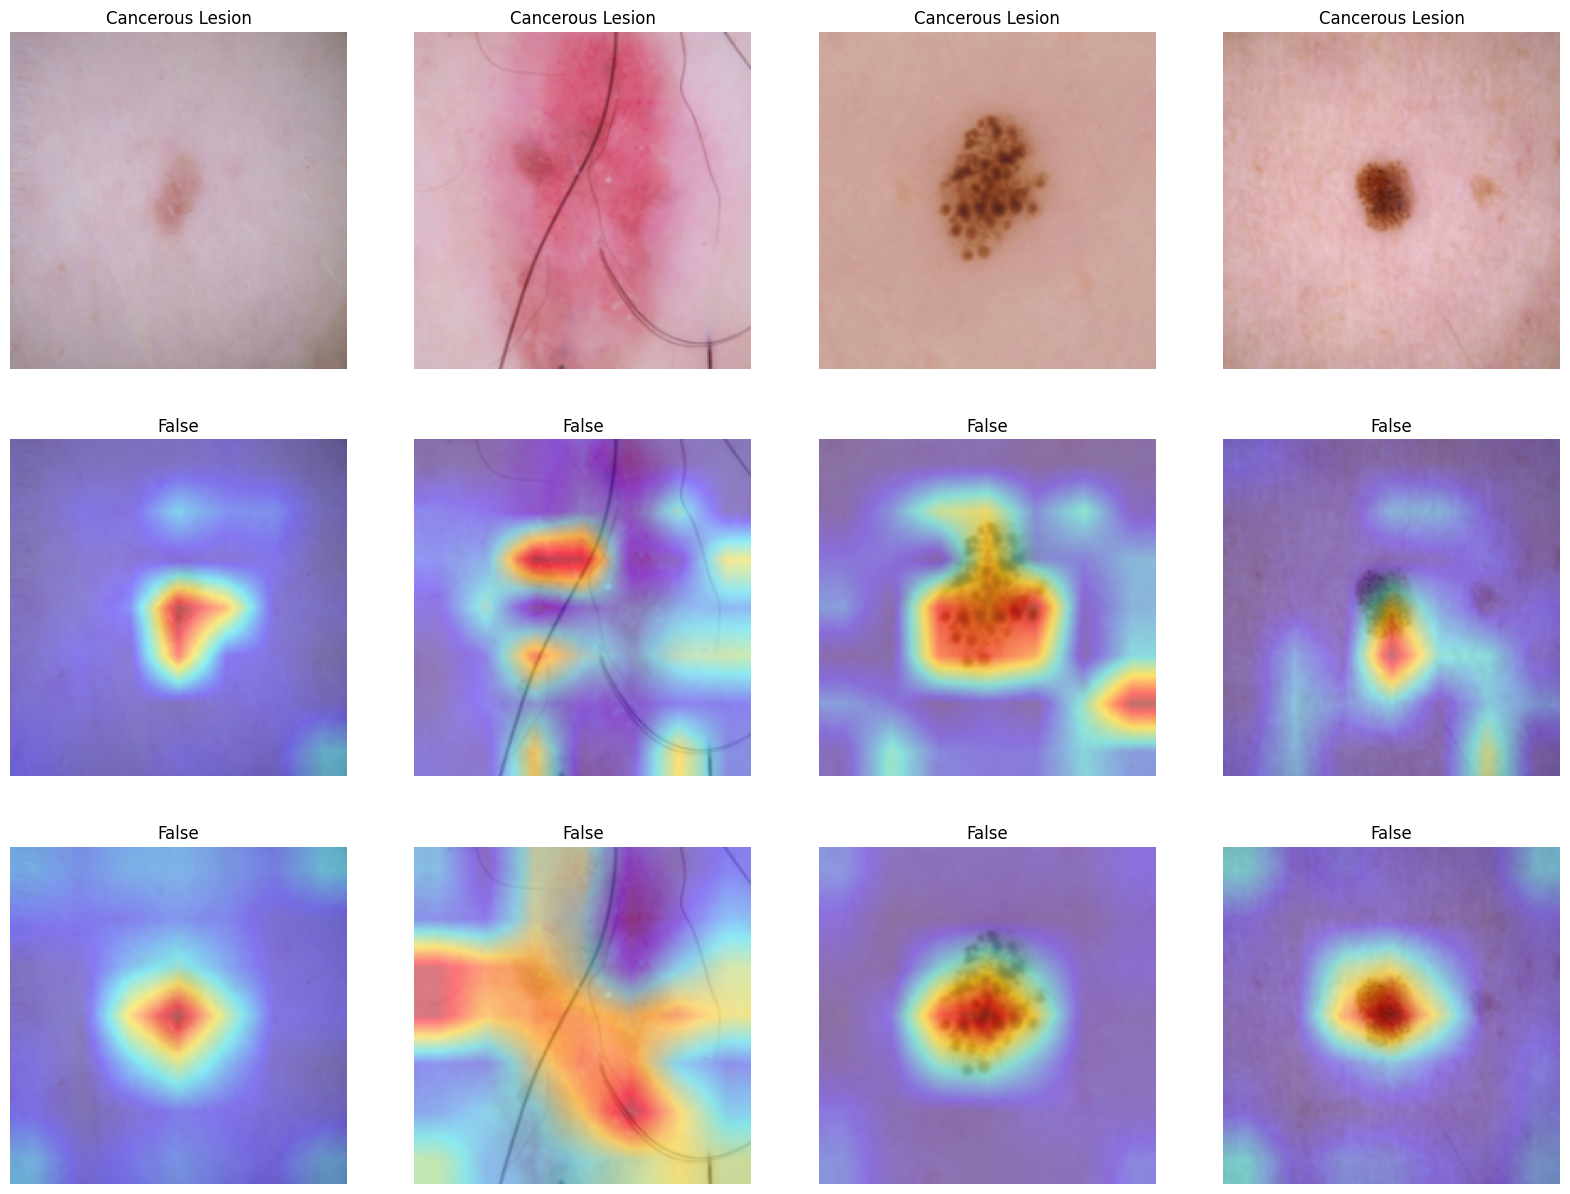

In [205]:
plt.figure(figsize=(20,15))

for i in range(4):
    #Row images
    plt.subplot(3,4,i + 1)
    img = img_vgg[i].permute(2,1,0).cpu().numpy()
    c_img = cv.resize(img,(200,200))
    plt.axis('off')
    plt.title(("Cancerous Lesion" if label[i] == 1 else "Benign Lesion"))
    plt.imshow(c_img)
    
    #Res net score cam
    plt.subplot(3,4,i + 1 + 4)
    img = img_resnet[i].permute(2,1,0).cpu().numpy()
    viz = show_cam_on_image(img, res_hitmaps[i], use_rgb=True,image_weight=0.6)
    c_img = cv.resize(viz,(200,200))
    plt.axis('off')
    plt.title(("True" if label[i] == resnet_result[i] else "False"))
    plt.imshow(c_img)
    
    #vgg16 score cam
    plt.subplot(3,4,i + 1 + 4 + 4)
    img = img_vgg[i].permute(2,1,0).cpu().numpy()
    viz = show_cam_on_image(img, vgg_hitmaps[i], use_rgb=True,image_weight=0.6)
    c_img = cv.resize(viz,(200,200))
    plt.axis('off')
    plt.title(("True" if label[i] == vgg_result[i] else "False"))
    plt.imshow(c_img)

plt.savefig("fNNN.jpg")  
# for i in range(4):
#     plt.subplot(3,4,i + 1)
    

# Metrics for model asssesment

In [113]:
resnet_dataloader = DataLoader(dataset= test_resnet,
                              batch_size= 64,
                              shuffle= False
                              )
inception_dataloader = DataLoader(dataset= test_inception,
                              batch_size= 64,
                              shuffle= False
                              )
vgg_dataloader = DataLoader(dataset= test_vgg,
                              batch_size= 64,
                              shuffle= False
                              )
mobilenet_dataloader = DataLoader(dataset= test_mobilenet,
                              batch_size= 64,
                              shuffle= False
                              )

In [93]:
from tqdm.auto import tqdm, trange
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryROC
from torchmetrics.classification import BinaryF1Score

In [114]:
def test(model, device, test_loader):
    
    percision = BinaryPrecision().to(device)
    recall =BinaryRecall().to(device)
    accuracy =BinaryAccuracy().to(device)
    ROC = BinaryROC(thresholds=None).to(device)
    f1_score = BinaryF1Score().to(device)
    
    model.to(device)
    model.eval()

    pred_list_valid = torch.tensor([]).to(device)
    target_list_valid = torch.tensor([]).to(device)
    with torch.inference_mode():
        for data, target in tqdm(test_loader):

            data, target = transform_norm(data).to(device), target.to(device)

            output = model(data).squeeze(dim =1)

            pred = torch.sigmoid(output)

#             pred = (pred > 0.5).float()

            pred_list_valid = torch.cat((pred_list_valid,pred),dim=0)
            target_list_valid = torch.cat((target_list_valid,target),dim=0)
        
        target_list_valid = target_list_valid.type(torch.LongTensor).to(device)
        test_roc = ROC(pred_list_valid,target_list_valid)
        pred_list_valid = (pred_list_valid > 0.5).float()
        pred_list_valid = pred_list_valid.type(torch.LongTensor).to(device)
        test_f1score = f1_score(pred_list_valid,target_list_valid).cpu().item()
        test_percision = percision(pred_list_valid,target_list_valid).cpu().item()
        test_recall = recall(pred_list_valid,target_list_valid).cpu().item()
        test_accuracy = accuracy(pred_list_valid,target_list_valid).cpu().item()
        
        
    return test_accuracy , test_percision , test_recall , test_f1score ,pred_list_valid.cpu().numpy() ,test_roc

In [115]:
resnet_accuracy , resnet_percision , resnet_recall , resnet_f1 ,resnet_label, resnet_roc = test(resnet, device, resnet_dataloader)
inception_accuracy , inception_percision , inception_recall , inception_f1 ,inception_label, inception_roc = test(inception, device, inception_dataloader)
vgg_accuracy , vgg_percision , vgg_recall , vgg_f1,vgg_label, vgg_roc = test(vgg, device, vgg_dataloader)
mobilenet_accuracy , mobilenet_percision , mobilenet_recall, mobilenet_f1, mobilenet_label, mobilenet_roc = test(mobilenet, device, mobilenet_dataloader)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [116]:
df2 = pd.DataFrame(np.array([[resnet_accuracy, resnet_percision, resnet_recall,resnet_f1],
                             [inception_accuracy, inception_percision, inception_recall,inception_f1],
                             [vgg_accuracy, vgg_percision, vgg_recall,vgg_f1],
                            [mobilenet_accuracy, mobilenet_percision , mobilenet_recall,mobilenet_f1]]),
                   columns=['accuracy', 'percision', 'recall','f1 score'], index=['resnet','inception','vgg','mobilenet'])
df2.to_excel("tabel.xlsx")

In [117]:
test_f = pd.read_csv("/kaggle/input/model-data/test.csv")

In [118]:
test_f["vgg"] = vgg_label
test_f["resnet"] = resnet_label
test_f["mobilenet"] = mobilenet_label
test_f["inception"] = inception_label

In [120]:
test_f.to_csv("results.csv")

In [126]:
a = (test_f.vgg == 1) & (test_f.resnet == 1) & (test_f.mobilenet == 1) & (test_f.inception == 1) & (test_f.label == 1)
b = (test_f.vgg == 0) & (test_f.resnet == 0) & (test_f.mobilenet == 0) & (test_f.inception == 0) & (test_f.label == 0)
test_f[b]

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,path,exists,label,vgg,resnet,mobilenet,inception
0,5366,HAM_0006175,ISIC_0024954,nv,follow_up,35.0,male,back,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,0,0,0,0,0
1,7363,HAM_0002244,ISIC_0034320,nv,histo,25.0,female,chest,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,0,0,0,0,0
2,3739,HAM_0004523,ISIC_0029984,nv,follow_up,45.0,female,lower extremity,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,0,0,0,0,0
4,8863,HAM_0005510,ISIC_0028166,nv,histo,30.0,female,lower extremity,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,0,0,0,0,0
5,5067,HAM_0001257,ISIC_0024614,nv,follow_up,35.0,female,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,4958,HAM_0002487,ISIC_0032503,nv,follow_up,55.0,female,trunk,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,0,0,0,0,0
1931,4511,HAM_0003552,ISIC_0029084,nv,follow_up,45.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,0,0,0,0,0
1933,5814,HAM_0005144,ISIC_0026130,nv,follow_up,40.0,female,trunk,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,0,0,0,0,0
1935,5353,HAM_0005687,ISIC_0027880,nv,follow_up,65.0,male,upper extremity,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,True,0,0,0,0,0


In [ ]:
c = (test_f.vgg == 1) & (test_f.resnet == 1) & (test_f.mobilenet == 1) & (test_f.inception == 1) & (test_f.label == 0)
d = (test_f.vgg == 0) & (test_f.resnet == 0) & (test_f.mobilenet == 0) & (test_f.inception == 0) & (test_f.label == 1)

In [128]:
test_f[a].to_csv("all_cancerous.csv")
test_f[b].to_csv("all_begnin.csv")
test_f[c].to_csv("false_positive.csv")
test_f[d].to_csv("false_negetive.csv")

In [130]:
a

0       False
1       False
2       False
3       False
4       False
        ...  
1933    False
1934    False
1935    False
1936     True
1937    False
Length: 1938, dtype: bool